### Quench dynamics with Emu-SV in presence of some noise channels

In this tutorial, we will introduce our EMU-SV master equation solver of a quench sequence in presence of effective noise channels or jump operators.  For more information related to effective noise, please take a look at the following pulser effective noise [documentation](https://pulser.readthedocs.io/en/stable/tutorials/effective_noise.html). This tutorial is based on `Quench dynamics` tutorial. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

#pulser imports
from pulser.devices import AnalogDevice
from pulser import Sequence, Register, Pulse
from pulser.channels import Rydberg
from pulser.noise_model import NoiseModel # effective noise or jump operators

#emulators imports
import emu_sv


In [2]:
# define the register arregement function and the device for the quench
def chain_coordinates(N,R1,R2):
    """Generate the coordinates of a chain of points arranged in two parallel 
    lines."""
    coords = [(-R2/2,i*R1-(N-1)/2*R1) for i in range(N)]
    coords = coords + [(R2/2,i*R1-(N-1)/2*R1) for i in range(N)]
    return coords


# device settings
VD = AnalogDevice.to_virtual()
VD = replace(
    VD, 
    max_atom_num=50,
    max_radial_distance=38,
    max_sequence_duration=None,
    channel_objects=(
        Rydberg.Global(48.69468613064179, 12.566370614359172),
    ))

The registers will be arranged in two parallel lines, each containing $N$ atoms, as generated by the function `chain_coordinates`. The atoms will be vertically separated by $R_1$ and horizontally by $R_2$ . The $U_i$ terms represent the interaction energies between pairs of atoms at various distances. For instance,  $U_1$ represents the interaction energy between nearest neighbors along the same line, separated by a distance $R_1$. $U_2$ is the interaction energy between atoms across the two parallel lines, separated by the horizontal distance $R_2$, and so on.

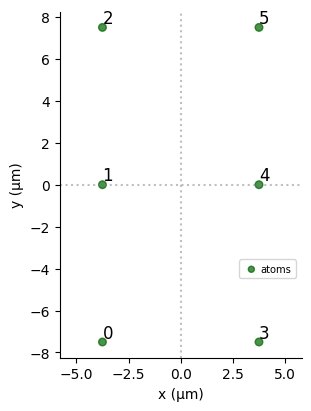

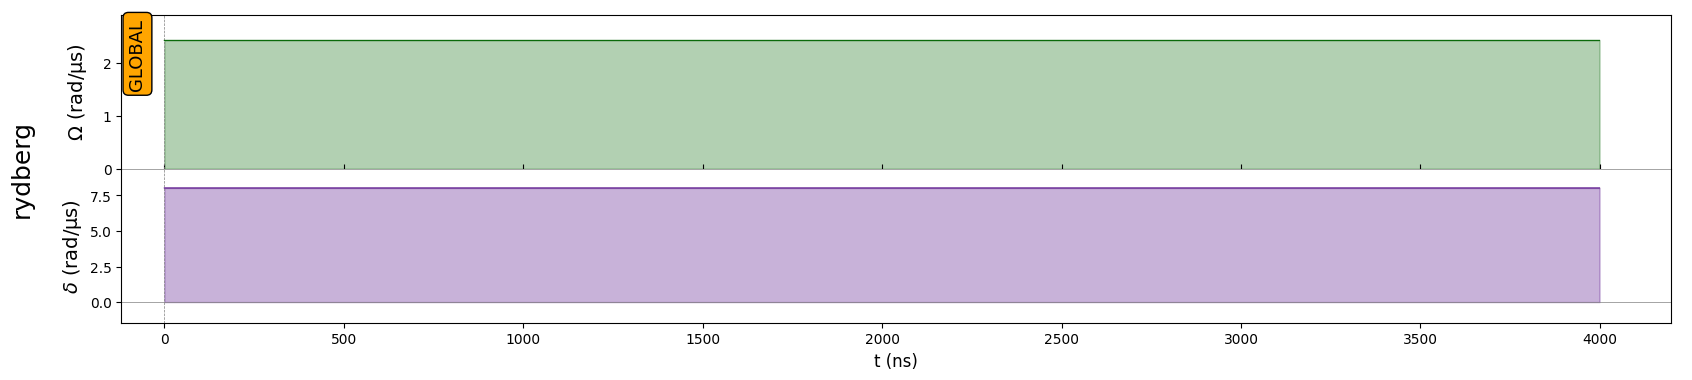

In [13]:
# Parameters for the system
N  = 3 # number of atoms in a line
R1 = 7.5 # vertical distance between atoms in a single chain
lam = 1
R2 = R1/(lam**(1/6)) # # Horizontal distance between the two parallel chains of atoms

U1 = VD.interaction_coeff/R1**6 #interaction with nearest neighbors in the same line
U2 = VD.interaction_coeff/R2**6 #interacion between atoms across two paralell lines
U3 = VD.interaction_coeff/(np.sqrt(R1**2+R2**2))**6 # interaction between diagonal neighbors
U4 = VD.interaction_coeff/(2*R1)**6 # second-nearest neighbors interaction in the same line
U5 = VD.interaction_coeff/(np.sqrt(4*R1**2+R2**2))**6 # second-nearest interaction across lines

coords_exact = chain_coordinates(N,R1,R2) # generate the coordinates of the atoms

hx = 1 
hz = 0 

t = 4000 # duration of the sequence
dt = 10 # time step

NN_coeff = U1/4
omega = 2*hx*NN_coeff
delta = (-2*hz*NN_coeff+U1+U2/2+U3+U4+U5) #compensate the interaction shift
T = t/1000*NN_coeff
dT = dt/1000*NN_coeff


# pulser register
qubits = dict(enumerate(coords_exact))
reg0 = Register(qubits)
reg0.draw()

#pulser sequence
seq = Sequence(reg0, VD)
seq.declare_channel("rydberg", "rydberg_global")
simple_pulse = Pulse.ConstantPulse(t, omega, delta, 0)
seq.add(simple_pulse, "rydberg")
seq.draw()


#### SVBackend, SVConfig and effective noise channels 

In order to run a noisy sequence, you need to instanciate *SVBackend*, *SVConfig* and pass the pulser `NoiseModel` instance to SVConfig. In this case, we are going to use 2 noise channels: `depolarizing` and `dephasing` both with rates equals to 0.1. 
In principle, one just needs to declare the noise channels or jump operators with their respective rates and EMU-SV will run with the master equation solver.

In [14]:
noise_model = NoiseModel(
        depolarizing_rate=0.1,
        dephasing_rate=0.1,
    )

In [15]:
basis = (
    "r",
    "g",
)
eval_times = [x / t for x in range(dt, t, 4 * dt)]  # must be from 0 to 1
occupation = emu_sv.Occupation(evaluation_times=eval_times, one_state=basis)
#NOTE: at the moment, not all the observables are supported by master equation solver. 


# emu-sv config
svconfig = emu_sv.SVConfig(
    dt=dt, observables=[occupation], noise_model=noise_model, gpu=False
)  # gpu = True
# svconfig = emu_sv.SVConfig(gpu=True,dt=dt,observables=[density])

# emu-sv backendsd
sim = emu_sv.SVBackend(seq, config=svconfig)
results = sim.run()

step = 1/400, RSS = 972.276 MB, Δt = 0.015 s
step = 2/400, RSS = 972.276 MB, Δt = 0.014 s
step = 3/400, RSS = 972.276 MB, Δt = 0.013 s
step = 4/400, RSS = 972.276 MB, Δt = 0.034 s
step = 5/400, RSS = 972.276 MB, Δt = 0.030 s
step = 6/400, RSS = 972.276 MB, Δt = 0.018 s
step = 7/400, RSS = 972.276 MB, Δt = 0.025 s
step = 8/400, RSS = 972.276 MB, Δt = 0.032 s
step = 9/400, RSS = 972.276 MB, Δt = 0.028 s
step = 10/400, RSS = 972.276 MB, Δt = 0.029 s
step = 11/400, RSS = 972.276 MB, Δt = 0.028 s
step = 12/400, RSS = 972.276 MB, Δt = 0.028 s
step = 13/400, RSS = 972.276 MB, Δt = 0.029 s
step = 14/400, RSS = 972.276 MB, Δt = 0.028 s
step = 15/400, RSS = 972.276 MB, Δt = 0.026 s
step = 16/400, RSS = 972.276 MB, Δt = 0.031 s
step = 17/400, RSS = 972.276 MB, Δt = 0.030 s
step = 18/400, RSS = 972.276 MB, Δt = 0.029 s
step = 19/400, RSS = 972.276 MB, Δt = 0.028 s
step = 20/400, RSS = 972.276 MB, Δt = 0.029 s
step = 21/400, RSS = 972.276 MB, Δt = 0.029 s
step = 22/400, RSS = 972.276 MB, Δt = 0.029

### Plot the evolution of the occupation $n_i$ of all the atoms

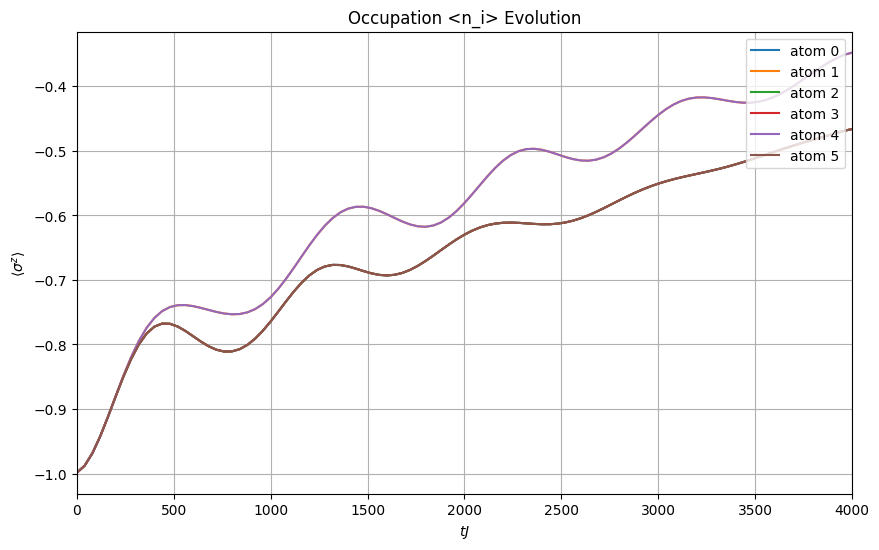

In [16]:
occupation_values = np.array(results.occupation)
times = np.arange(0,t+dt,4*dt)

plt.figure(figsize=(10, 6)) 

for i in range(2*N):
    result_plot = occupation_values[:,i]
    plt.plot(times,2*result_plot-1,label=f'atom {i}')

plt.title('Occupation <n_i> Evolution')
plt.xlim(0,t)

plt.xlabel(r'$tJ$')
plt.ylabel(r'$\langle \sigma^z \rangle$')
plt.grid()

plt.legend(loc='upper right')
plt.show()